In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import mode

%matplotlib inline

from hbtp import HBTReader
from src.prof import HBTProfileReader
from src.cmh import HBTHistoryReader
from src import read
from src import cosmology
from src import nfw
from src import einasto

In [2]:
# plt.style.use('paper')

### Analysis parameters

In [2]:
grav = "GR_b64n512"
prof = "nfw"
snap = 122
NFW_f = 0.02
nbins = 20
bin = 10

r = HBTReader("./data/%s/subcat" % grav)
prof_reader = HBTProfileReader("./data/%s/subcat" % grav)
hist_reader = HBTHistoryReader("./data/%s/subcat" % grav)

zs = pd.read_csv(
    "./data/redshift_list.txt",
    delimiter=" ",
    header=None,
    names=["snap", "z"]
).set_index("snap")

### Subhalo mass function

In [4]:
def subhalo_mass_function(r, snap):
    ss = r.LoadSubhalos(snap)
    ss = ss[(ss['HostHaloId'] != -1) & (ss['BoundM200Crit'] > 0.0)& (ss['Nbound'] >= 20)]

    counts, bin_edges = np.histogram(np.log10(ss['Nbound']), 20)
    ss = np.lib.recfunctions.append_fields(ss, 'bin',\
        np.digitize(np.log10(ss['BoundM200Crit']), bin_edges),\
        usemask=False)
    bins = 0.5*(bin_edges[1:] + bin_edges[:-1])
    return bins, np.log10(counts)

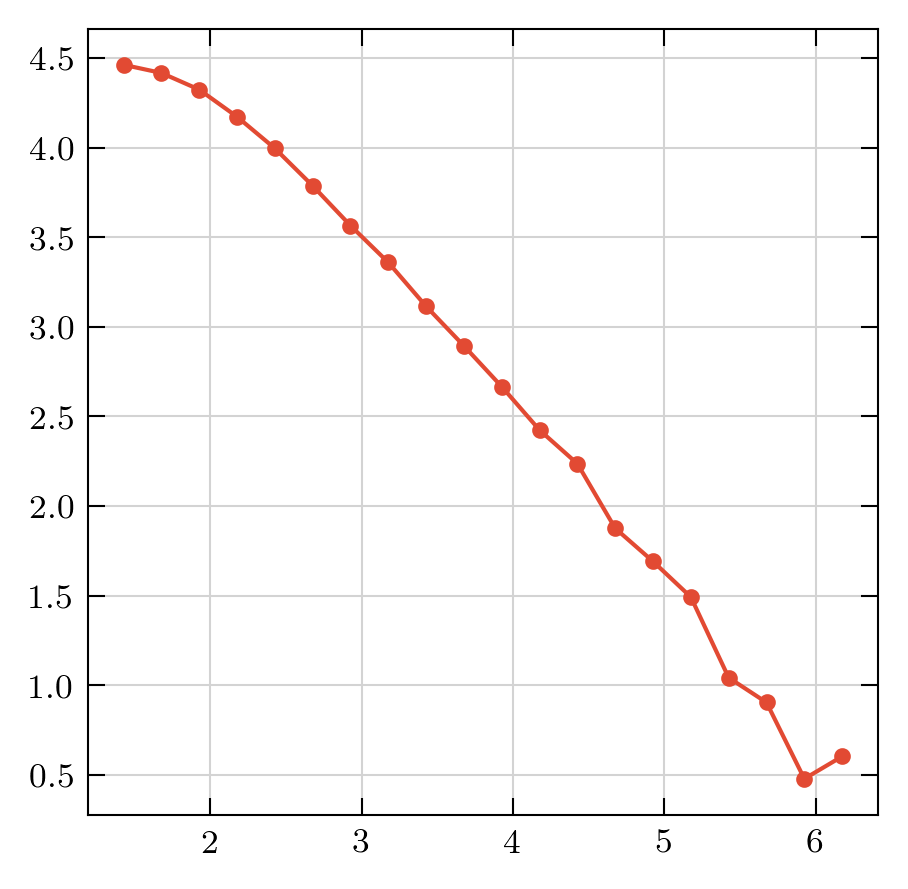

In [5]:
plt.plot(*subhalo_mass_function(r, snap), color='C0', marker='.')

### Halo mass function

Create a histogram to contain all FoF haloes, and use the bins to digitize the `M200Crit` field.

In [3]:
def read_haloes(r, snap):
    hs = r.LoadHostHalos(snap)[['HaloId','R200CritComoving','M200Crit']]
    hs = hs[hs['M200Crit'] >= 20]
    hs = hs[hs['M200Crit'] >= 20]
    hs['M200Crit'] = 1e10*hs['M200Crit']
    return hs
    
def bin_haloes(haloes, bin_column, bin_edges, transform=lambda x: x):
    hs = np.lib.recfunctions.append_fields(
        haloes,
        'bin',
        np.digitize(
            transform(haloes[bin_column]),
            bin_edges[1:],
            right=True
        ),
        usemask=False,
    )
    return hs

def halo_mass_function(r, snap, nbins):
    hs = read_haloes(r, snap)
    counts, bin_edges = np.histogram(np.log10(hs['M200Crit']), nbins)
    hs = bin_haloes(hs, 'M200Crit', bin_edges, lambda x: np.log10(x))
    bins = 0.5*(bin_edges[1:] + bin_edges[:-1])
    return bins, np.log10(counts)

/cosma/home/dp004/dc-oles1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


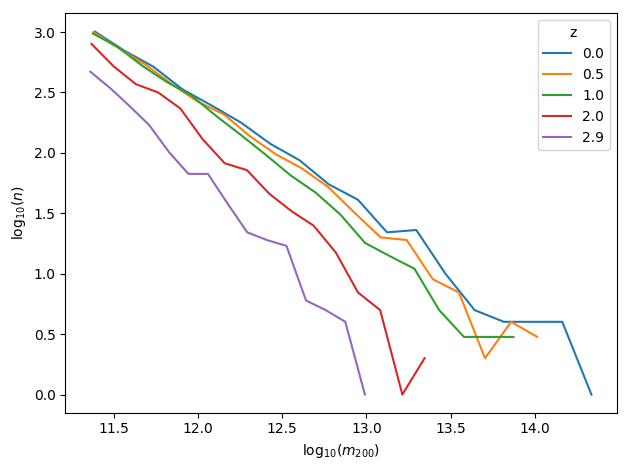

In [4]:
fig, ax = plt.subplots(1)
ax.set_xlabel(r"$\log_{10}(m_{200})$")
ax.set_ylabel(r"$\log_{10}(n)$")

for _snap in [122, 93, 78, 61, 51]:
    ax.plot(*halo_mass_function(r, _snap, 18), label="%.1f"%(zs.loc[_snap].values[0]))
ax.legend(title="z")

fig.tight_layout()

/cosma/home/dp004/dc-oles1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


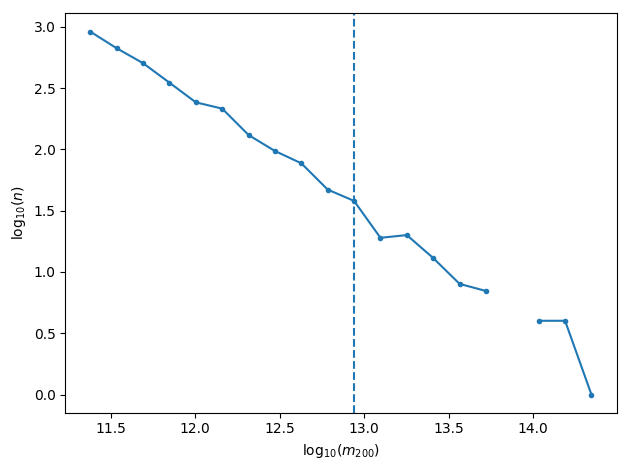

In [5]:
fig, ax = plt.subplots(1)
ax.set_xlabel(r"$\log_{10}(m_{200})$")
ax.set_ylabel(r"$\log_{10}(n)$")

ax.axvline(halo_mass_function(r, snap, nbins)[0][bin], color='C0', linestyle='--')
ax.plot(*halo_mass_function(r, snap, nbins), color='C0', marker='.')

fig.tight_layout()

### Binning

In [23]:
hs = read_haloes(r, snap)
_, bin_edges = np.histogram(np.log10(hs['M200Crit']), nbins)
hs = bin_haloes(hs, 'M200Crit', bin_edges, lambda x: np.log10(x))

### Concentration-mass relation

In [26]:
_m = 0.5*(bin_edges[1:] + bin_edges[:-1])
_c = - np.ones_like(_m)

for i in range(nbins):
    try:
        _c[i] = fit_nfw(
            list(hs[hs['bin'] == i]['HaloId']),
            snap,
        )[-1][0]
    except:
        pass

_c = np.log10(_c)

INFO:root:Retrieving profile for halos [[1180, 1328, 1406, 1477, 1591, 1603, 1606, 1617, 1654, 1667, 1669, 1690, 1721, 1732, 1763, 1825, 1841, 1861, 1868, 1880, 1881, 1896, 1914, 1961, 1968, 1971, 1985, 1987, 2009, 2020, 2023, 2027, 2034, 2055, 2076, 2079, 2082, 2090, 2103, 2116, 2134, 2145, 2183, 2186, 2190, 2201, 2207, 2224, 2228, 2229, 2241, 2248, 2253, 2255, 2256, 2258, 2265, 2266, 2271, 2275, 2276, 2282, 2285, 2304, 2307, 2308, 2310, 2312, 2320, 2321, 2324, 2325, 2328, 2336, 2337, 2344, 2353, 2370, 2372, 2374, 2377, 2381, 2383, 2390, 2391, 2393, 2397, 2398, 2402, 2403, 2414, 2415, 2420, 2424, 2428, 2432, 2437, 2441, 2458, 2463, 2470, 2472, 2474, 2475, 2476, 2477, 2480, 2483, 2484, 2488, 2489, 2491, 2492, 2495, 2496, 2501, 2502, 2504, 2509, 2511, 2514, 2516, 2518, 2521, 2523, 2528, 2531, 2532, 2534, 2537, 2539, 2541, 2544, 2545, 2546, 2549, 2550, 2555, 2559, 2561, 2563, 2567, 2568, 2569, 2573, 2575, 2578, 2582, 2583, 2593, 2594, 2595, 2599, 2601, 2602, 2604, 2606, 2607, 2608, 2610,

INFO:root:Retrieving profile for halos [[651, 678, 706, 762, 778, 808, 830, 862, 873, 914, 917, 929, 945, 955, 957, 960, 964, 967, 973, 1001, 1014, 1030, 1035, 1036, 1047, 1049, 1050, 1062, 1087, 1094, 1105, 1107, 1110, 1119, 1124, 1127, 1134, 1147, 1150, 1155, 1163, 1164, 1170, 1182, 1189, 1191, 1194, 1199, 1206, 1208, 1226, 1227, 1230, 1232, 1237, 1238, 1247, 1256, 1258, 1273, 1274, 1275, 1282, 1283, 1284, 1287, 1289, 1292, 1293, 1295, 1298, 1299, 1300, 1303, 1305, 1308, 1311, 1313, 1314, 1315, 1319, 1321, 1322, 1326, 1327, 1334, 1335, 1337, 1340, 1343, 1345, 1347, 1350, 1354, 1355, 1357, 1361, 1365, 1366, 1367, 1369, 1371, 1373, 1377, 1378, 1379, 1381, 1385, 1386, 1387, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1404, 1405, 1408, 1410, 1411, 1412, 1413, 1414, 1416, 1417, 1421, 1423, 1424, 1426, 1429, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1444, 1445, 1447, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1457, 1458, 1460, 1461, 1463, 

INFO:root:Retrieving profile for halos [[128, 130, 149, 171, 179, 184, 192, 199, 200, 215, 230, 235, 236, 238, 240, 245, 249, 251, 255, 258, 260, 261, 262, 263, 266, 267, 268, 269, 270, 271, 273, 274, 275, 276, 277, 280, 281, 282, 283, 285, 288, 290, 291, 292, 293, 294, 296, 297, 298, 300, 304, 305, 306, 307, 308, 309, 310, 311, 312, 316, 317, 318, 319, 320, 321, 322, 323, 325, 326, 329, 330, 331, 332, 333, 334, 341, 342, 345, 346, 347, 348, 352, 356, 359, 360, 364, 365, 366, 369, 370, 372, 376, 378, 381, 384, 387, 394]]
INFO:root:Retrieving profile for halos [[73, 86, 109, 133, 134, 156, 158, 163, 164, 165, 167, 168, 169, 172, 174, 177, 180, 181, 183, 185, 186, 187, 188, 190, 191, 193, 194, 195, 197, 198, 201, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 216, 218, 219, 220, 221, 223, 224, 225, 226, 227, 228, 229, 231, 232, 233, 234, 237, 239, 241, 242, 243, 246, 247, 248, 250, 252, 254, 256, 259, 264, 265, 272, 284, 287]]
INFO:root:Retrieving profile for halos [[95, 98,

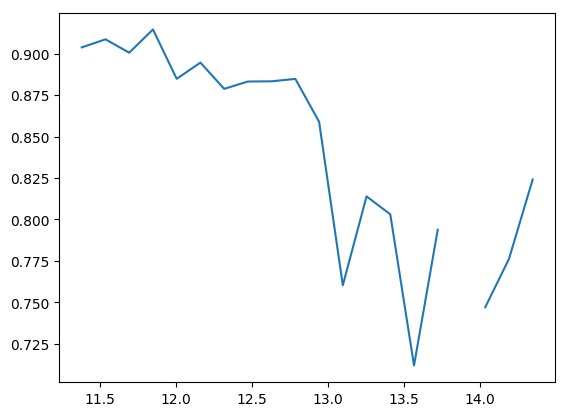

In [28]:
plt.plot(_m, _c)

### Binning again

Only keep haloes in each bin for individual bin plots:

In [40]:
hs = hs[hs['bin'] == bin]

### Density profile

In [12]:
def read_profiles(ids, snap=snap):
    return np.array(prof_reader.GetHostProfile([ids,], snap), dtype=float)

In [87]:
def halo_profiles(r, ids, prof):
    ps = read_profiles(ids)
    xmin = 0.5 * np.cbrt((4.0 * np.pi)/(3.0 * np.sum(np.mean(ps, axis=0))))
    ps = np.divide(ps.T, np.sum(ps, axis=1)).T
    x = np.linspace(-2.0, 0.0, 20)
    # vol = np.diff(np.power(np.append([0.0], np.power(10.0, x)), 3.0))
    xmax = 0.8
    idx = np.where((np.power(10, x) < xmax) & (np.power(10, x) > xmin))
    
    if prof == 'nfw':

        def f(x, c):
            return np.log10(nfw.m(np.power(10.0, x), c))

        fit = curve_fit(
         f,
         x[idx],
         np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx],
        )
        c = fit[0][0]

        rho_s = np.log10(nfw.rho_enc(1.0/c, c))

        return np.log10(ps), x, np.log10(np.median(ps, axis=0)), idx, rho_s, c

    elif prof == 'einasto':

        def f(x, c, a):
            return np.log10(einasto.m(np.power(10.0, x), c, a))

        fit = curve_fit(
         f,
         x[idx],
         np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx],
        )
        c, a = fit[0][0], fit[0][1]

        rho_s = np.log10(einasto.rho_enc(1.0/c, c, a))

        return np.log10(ps), x, np.log10(np.median(ps, axis=0)), idx, rho_s, c, a

    else:
        raise ValueError("Profile must be either 'nfw' or 'einasto'")

c = halo_profiles(prof_reader, list(hs['HaloId']), prof)[5]

INFO:root:Retrieving profile for halos [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,

/cosma/home/dp004/dc-oles1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


In [88]:
c

7.899156267541599

In [13]:
def fit_nfw(ids, snap=snap):
    ps = read_profiles(ids, snap)
    xmin = 0.5 * np.cbrt((4.0 * np.pi)/(3.0 * np.sum(np.mean(ps, axis=0))))
    ps = np.divide(ps.T, np.sum(ps, axis=1)).T
    x = np.linspace(-2.0, 0.0, 20)
    # vol = np.diff(np.power(np.append([0.0], np.power(10.0, x)), 3.0))
    xmax = 0.8
    idx = np.where((np.power(10, x) < xmax) & (np.power(10, x) > xmin))

    def f(x, c):
        return np.log10(nfw.m(np.power(10.0, x), c))

    popt, pcov = curve_fit(
     f,
     x[idx],
     np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx],
    )
    
    chi2 = np.sum(((np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx] - 
                    f(x[idx], *popt)))**2)
    L = np.exp(-chi2)
    AIC = 2 * 1 - 2 * np.log(L)
    BIC = np.log(np.size(idx)) * 1 - 2 * np.log(L)
    
    return L, AIC, BIC, chi2, popt

def fit_einasto(ids, snap=snap):
    ps = read_profiles(ids, snap)
    xmin = 0.5 * np.cbrt((4.0 * np.pi)/(3.0 * np.sum(np.mean(ps, axis=0))))
    ps = np.divide(ps.T, np.sum(ps, axis=1)).T
    x = np.linspace(-2.0, 0.0, 20)
    # vol = np.diff(np.power(np.append([0.0], np.power(10.0, x)), 3.0))
    xmax = 0.8
    idx = np.where((np.power(10, x) < xmax) & (np.power(10, x) > xmin))

    def f(x, c, a):
        return np.log10(einasto.m(np.power(10.0, x), c, a))

    popt, pcov = curve_fit(
     f,
     x[idx],
     np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx],
    )
    
    chi2 = np.sum(((np.log10(np.median(np.cumsum(ps, axis=1), axis=0))[idx] - 
                f(x[idx], *popt)))**2)
    L = np.exp(-chi2)
    AIC = 2 * 2 - 2 * np.log(L)
    BIC = np.log(np.size(idx)) * 2 - 2 * np.log(L)
    
    return L, AIC, BIC, chi2, popt

In [13]:
fit_nfw(hs['HaloId'])

INFO:root:Retrieving profile for halos [[95, 98, 110, 113, 116, 117, 118, 121, 124, 125, 127, 129, 131, 132, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 151, 152, 153, 154, 155, 157, 159, 160, 161, 162, 166, 170, 173, 175, 176, 178, 182, 202]]


(0.9903289677870772,
 2.019436200711619,
 2.727486401813829,
 0.009718100355809578)

In [14]:
fit_einasto(hs['HaloId'])

INFO:root:Retrieving profile for halos [[95, 98, 110, 113, 116, 117, 118, 121, 124, 125, 127, 129, 131, 132, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 151, 152, 153, 154, 155, 157, 159, 160, 161, 162, 166, 170, 173, 175, 176, 178, 182, 202]]
/cosma/home/dp004/dc-oles1/src/hbtp/src/einasto.py:7: RuntimeWarning: invalid value encountered in power
  return gammainc(3.0 / a, (2.0 / a) * np.power(u, a))


(0.9994162607094433,
 4.001167819465337,
 5.417268221669757,
 0.0005839097326686853)

In [15]:
halo_profiles(prof_reader, hs['HaloId'], 'einasto')[5:]

INFO:root:Retrieving profile for halos [[95, 98, 110, 113, 116, 117, 118, 121, 124, 125, 127, 129, 131, 132, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 151, 152, 153, 154, 155, 157, 159, 160, 161, 162, 166, 170, 173, 175, 176, 178, 182, 202]]
/cosma/home/dp004/dc-oles1/src/hbtp/src/einasto.py:7: RuntimeWarning: invalid value encountered in power
  return gammainc(3.0 / a, (2.0 / a) * np.power(u, a))


(6.952734560253492, 0.172666949034731)

In [16]:
np.log10(hs['M200Crit']).max()

12.85651

INFO:root:Retrieving profile for halos [[95, 98, 110, 113, 116, 117, 118, 121, 124, 125, 127, 129, 131, 132, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 151, 152, 153, 154, 155, 157, 159, 160, 161, 162, 166, 170, 173, 175, 176, 178, 182, 202]]


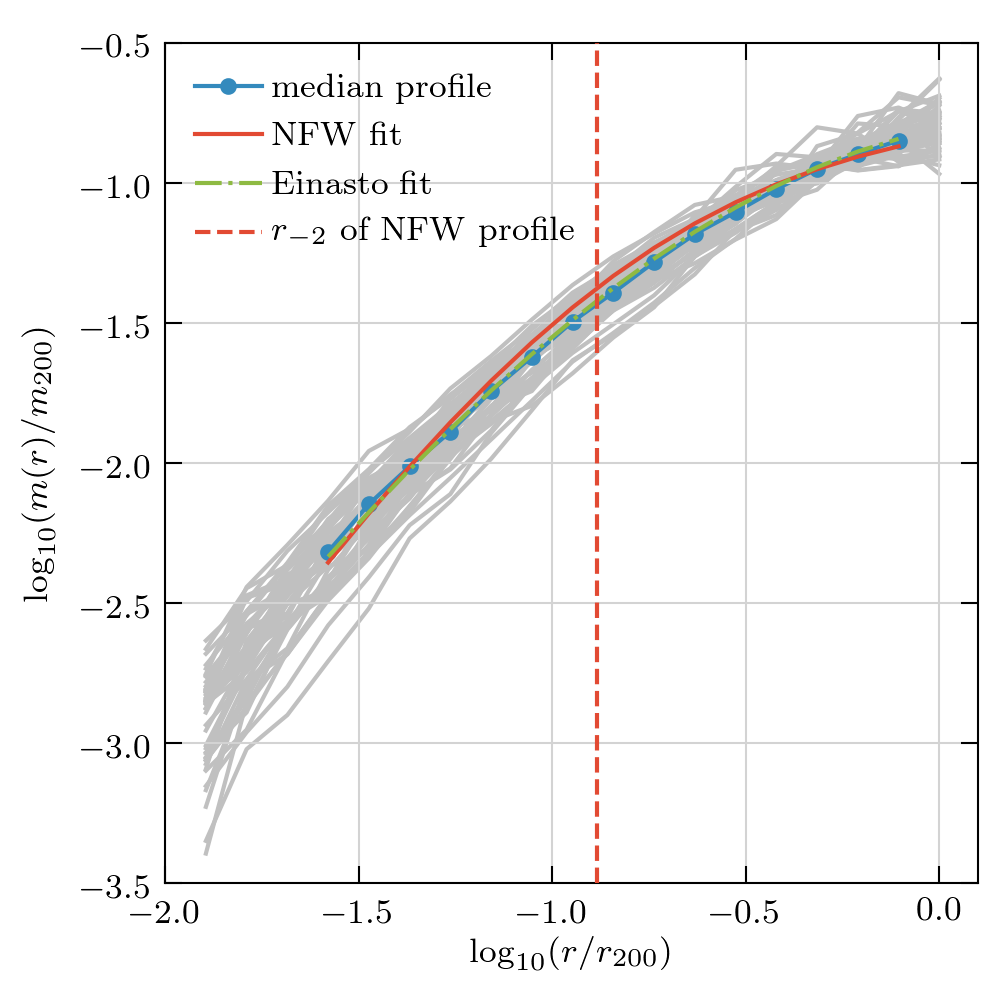

In [17]:
def plot_halo_profiles(ax, prof, *args):
    if prof == 'nfw':
        ps, x, p, idx, rho_s, c = args
    elif prof == 'einasto':
        ps, x, p, idx, rho_s, c, a = args
    else:
        raise ValueError("Profile must be either 'nfw' or 'einasto'")
        
#     s1 = np.percentile(ps, 32.0, axis=0)
#     s2 = np.percentile(ps, 68.0, axis=0)

    ax.set_xlabel(r"$\log_{10}(r / r_{200})$")
    ax.set_ylabel(r"$\log_{10}(m(r) / m_{200})$")
    ax.set_xlim([-2.0, 0.1])
    ax.set_ylim([-3.5, -0.5])

    [ax.plot(x[1:], _[1:], color='silver', zorder=0) for _ in ps]
    ax.plot(x[idx], p[idx], color='C1', marker='.',linewidth=1,  zorder=1, label='median profile')
    
    ax.plot(x[idx], np.log10(nfw.m_diff(np.power(10.,x), c)[idx]),
        color='C0', linestyle='-', linewidth=1, zorder=2, label='NFW fit')

    ax.plot(x[idx], np.log10(einasto.m_diff(np.power(10.,x), 6.952734560253492, 0.172666949034731)[idx]),
        color='C5', linestyle='-.', linewidth=1, zorder=2, label='Einasto fit')

    ax.axvline(np.log10(1.0/c), color='C0', linestyle='--', zorder=4, linewidth=1, label='$r_{-2}$ of NFW profile')

    ax.legend()

fig, ax = plt.subplots(1)
plot_halo_profiles(ax, prof, *halo_profiles(prof_reader, hs['HaloId'], prof))
fig.tight_layout()

# fig.savefig("./plots/prof.pdf")

### Collapsed Mass History

In [18]:
def F(profile, *args):
    if profile == 'nfw':
        c = args[0]
        return nfw.m(1.0/c, c)
    elif profile == 'einasto':
        c, a = args
        return einasto.m(1.0/c, c, a)
    else:
        raise ValueError("Profile must be either 'nfw' or 'einasto'")

In [19]:
def halo_mass_history(grav, snap, hs, F):
    ms = np.array(
        pd.read_csv("./output/cmh.f%03d.%s.%03d.csv" % (100 * NFW_f, grav, snap))\
            .set_index('HostHaloId')\
            .fillna(0.0)\
            .loc[hs['HaloId']]\
            .dropna(),
        dtype=float
    )
    ms = np.divide(ms.T, ms[:,-1]).T
    m = np.median(ms, axis=0)

    zs = read.snaps()
    rho = cosmology.rho_c(
        np.array([
            zs[zs['Snapshot'] == s][0]['Redshift']
            for s in np.arange(1+snap-ms.shape[1], 1+snap)
        ])) / \
        cosmology.rho_c(zs[zs['Snapshot'] == snap][0]['Redshift'])

    m_f = F*m[-1]
    y1, y2 = m[m > m_f][0], m[m < m_f][-1]
    x1, x2 = rho[m > m_f][0], rho[m < m_f][-1]
    rho_f = (np.log10(x1/x2)/np.log10(y1/y2))*(np.log10(m_f/y1))+np.log10(x1)

    return ms, rho, m, rho_f

In [20]:
F(prof, c)

0.15147945432671026

In [21]:
F('einasto', 6.952734560253492, 0.172666949034731)

0.16014587294413327

/cosma/home/dp004/dc-oles1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/cosma/home/dp004/dc-oles1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


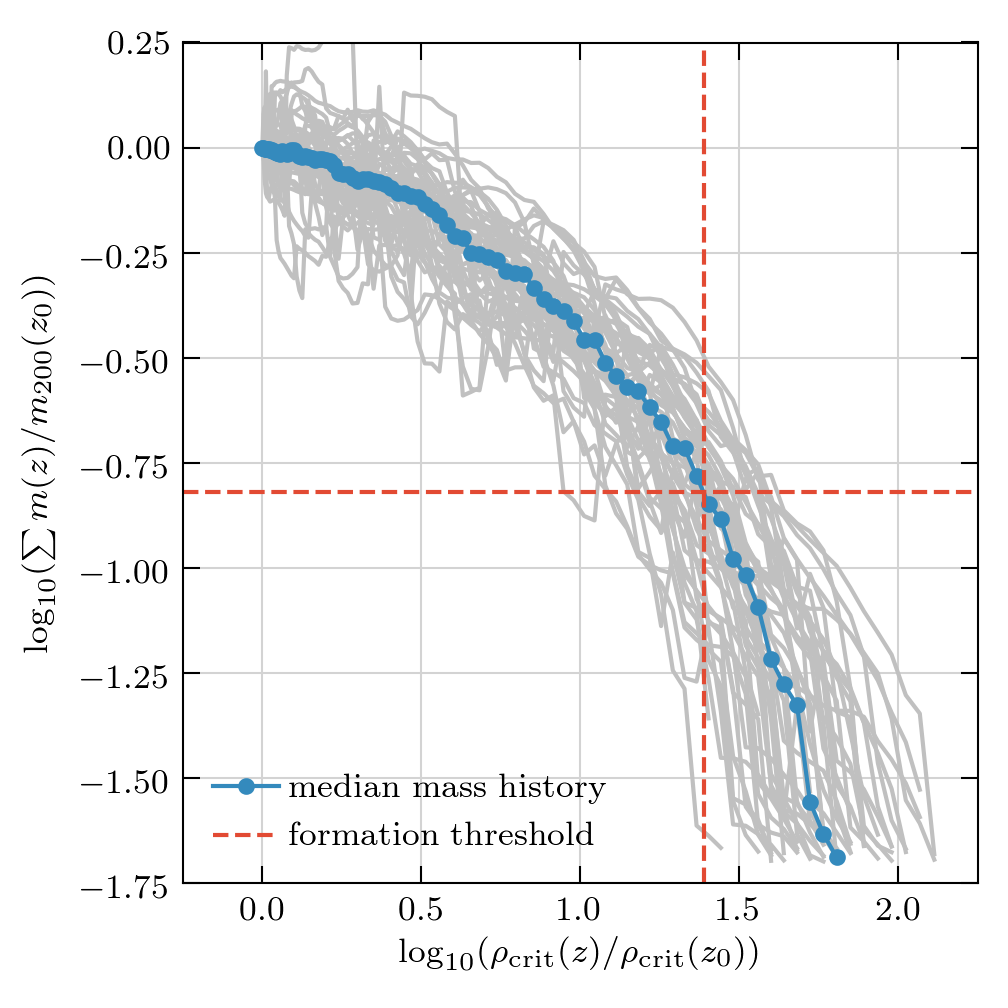

In [22]:
def plot_halo_mass_history(ax, *args):
    ms, rho, m, rho_f = args
    
    ax.set_xlabel(r"$\log_{10}(\rho_{\mathrm{crit}}(z) / \rho_{\mathrm{crit}}(z_0))$")
    ax.set_ylabel(r"$\log_{10}(\sum m(z) / m_{200}(z_0))$")
    ax.set_xlim([-0.25, 2.25])
    ax.set_ylim([-1.75, 0.25])

    [ax.plot(np.log10(rho), np.log10(_), color='silver') for _ in ms]
    ax.plot(np.log10(rho), np.log10(m), color='C1', marker='.', linewidth=1, label='median mass history')
    ax.axvline(rho_f, color='C0', linestyle='--', linewidth=1, label='formation threshold')
    ax.axhline(np.log10(F(prof, c)), color='C0', linestyle='--', linewidth=1)
    ax.legend()

fig, ax = plt.subplots(1)
plot_halo_mass_history(ax, *halo_mass_history(grav, snap, hs, F(prof, c)))
fig.tight_layout()

# fig.savefig("./plots/cmh.pdf")

Haloes number 2, 5 and 12 are the ones with the most pronounced increase-then-decrease mass histories

/cosma/home/dp004/dc-oles1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


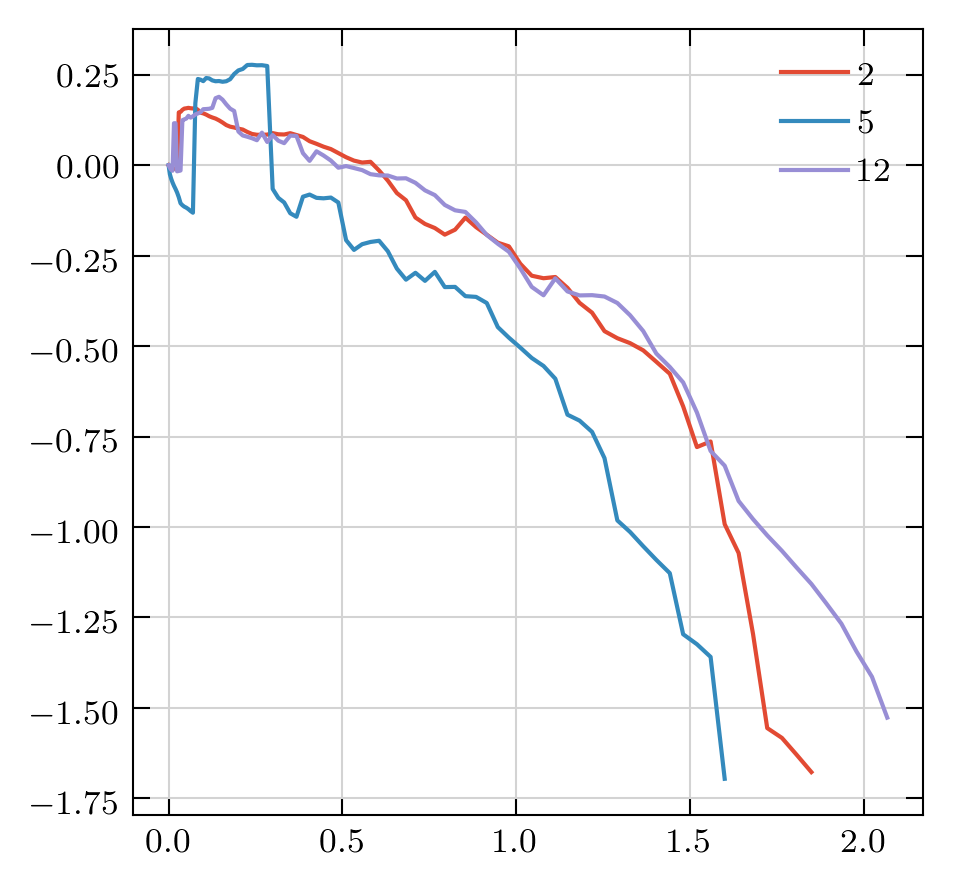

In [47]:
zs = read.snaps()
ms = np.array(
    pd.read_csv("./output/cmh.f%03d.%s.%03d.csv" % (100 * NFW_f, grav, snap))\
        .set_index('HostHaloId')\
        .fillna(0.0)\
        .loc[hs['HaloId']]\
        .dropna(),
    dtype=float
)
ms = np.divide(ms.T, ms[:,-1]).T
    
x = cosmology.rho_c(
    np.array([
        zs[zs['Snapshot'] == s][0]['Redshift']
        for s in np.arange(1+snap-ms.shape[1], 1+snap)
    ])) / \
    cosmology.rho_c(zs[zs['Snapshot'] == snap][0]['Redshift'])
    
fig, ax = plt.subplots(1)    

for i in [2, 5, 12]:
    ax.plot(np.log10(x), np.log10(ms[i,:]), label=i)

ax.legend()